In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

1. 데이터 확인

In [2]:
#MNIST dataset

train_dset = datasets.MNIST('../data', train=True, download=True,transform=transforms.ToTensor())
test_dset = datasets.MNIST('../data', train=False,transform=transforms.ToTensor(), download=True)

print('number of training data: ', len(train_dset))
print('number of test data ', len(test_dset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

number of training data:  60000
number of test data  10000


Image
Shape of image	:  torch.Size([1, 28, 28])
10'th row of this image	: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0157, 0.2235, 0.9490, 0.9882, 0.7451, 0.2549, 0.0196, 0.0471, 0.7137,
        0.9882, 0.9922, 0.4549, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
Label
label:  9


<function matplotlib.pyplot.show(*args, **kw)>

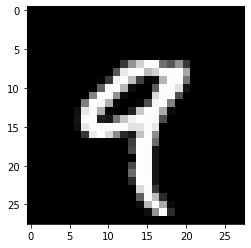

In [3]:
#데이터 확인

"""

TODO: train_dset[*] 의 숫자값을 바꾸어 데이터를 다른 걸 출력해보자.
-> train_dset[4]
"""
image, label = train_dset[4]

print('Image')
print('=========================================')
print('Shape of image\t: ', image.shape)
print('10\'th row of this image\t:', image[0][9])

print('Label')
print('=========================================')
print('label: ', label)

from matplotlib import pyplot as plt
# pytorch에서 불러오는 MNIST 데이터의 경우 [1, 28, 28]로 구성된다.
# 따라서 1을 없애야 이미지를 그릴 수 있다.
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.show

2. Training and Test

In [4]:
"""
TODO: batch_size 를 바꾸어보자

->  train_loader의 크기는 600(60000/100), test_loader의 크기는 100(10000/100)
"""
#shuffle하는 이유는 데이터의 순서를 학습하지 못하게 하는 것
train_loader = torch.utils.data.DataLoader(train_dset, batch_size = 100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size = 100, shuffle=False)

In [5]:
#Training
def train(model, train_loader, optimizer, i_epoch, device):
    model.train()
    for i, (image, target) in enumerate(train_loader):
        image = image.to(device)
        output = model(image) #model 에 image를 넣어 MLP거치게함
        loss = F.cross_entropy(output, target) #비용함수정의
        # F.cross_entropy 비용함수에 소프트맥스 함수까지 포함하고 있음

        model.zero_grad()
        loss.backward() # Backpropagation 을 통해 계산된 Gradient 값을 할당
        optimizer.step() # 한 step씩 움직인다


         #러닝 커브 그리기
        loss_value.append(loss.detach().numpy())

        #100번쨰 마다 loss 출력
        if i%100==0: 
            print("epoch: {}, iteration: {}, loss: {}".format(i_epoch, i, loss.item()))

In [6]:
#Test
def test(model, test_loader, i_epoch, device):
    model.eval()
    accurate = 0
    test_loss = 0

    with torch.no_grad(): #backward propagation 을 진행하기 때문에 torch 자체적인 gradient tracking 작업하는 것을 끄며 메모리 아낌
        for i, (image, target) in enumerate(test_loader):
            image = image.to(device)
            output = model(image)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            prediction = torch.argmax(output, dim=1) #dim=1 : 0번째 인덱스는 type 호출
            accurate += prediction.eq(target.view_as(prediction)).sum().item() # dict 형태에서 맞은 값 저장


    accuracy = accurate / len(test_loader.dataset)
    #러닝커브 그리기
    accuracy_value.append(accuracy)
    print("epoch: {}, accuracy: {}".format(i_epoch, accuracy))


3. Model

In [29]:
"""
TODO: 모델 Customization! 레이어 개수나 레이어 차원, 활성화 함수를 바꾸어보자.

데이터의 형태를 주의하면서 바꾸어 볼 것~


"""
# Using nn.Sequential

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__() #net 내의 메소드 상속받아 사용가능

        self.fc = nn.Sequential( 
            nn.Linear(28 * 28, 512),  #nn.Linear : 선형회귀
            # 1X 784 product 784 X 512 -> 1 X 512 에서 가중치 정보를 담는 열벡터 생성 wx + b 의 값
            nn.ReLU(), # sigmoid통과
            nn.Linear(512, 256), 
            nn.ReLU(),
            nn.Linear(256,10)
           )

    def forward(self, x):
        x = x.view(-1, 28 * 28) # x vector 의 size를 [1, 28*28]의 열벡터로 변환
        return self.fc(x)

In [30]:
#else

'''
class net(nn.Module):
    def __init__(self):
        super(net,self).__init__() 
        self.fc1 = nn.Linear(28*28,512) 
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256,10)

    def forward(self,x): # train 안의 forward 를 override  
        x = x.view(-1,28*28) # x Vector 의 size 를 [1,28*28] 의 열벡터로 변환
        x = self.fc1(x) # 1X 784 product 784 x 512 -> 1 X 512 에서 가중치 정보를 담는 열벡터 생성. wx + b 의 값
        x = F.sigmoid(x) 
        x = self.fc2(x) 
        x = F.sigmoid(x)
        x = self.fc3(x)
        return x
'''

'\nclass net(nn.Module):\n    def __init__(self):\n        super(net,self).__init__() \n        self.fc1 = nn.Linear(28*28,512) \n        self.fc2 = nn.Linear(512, 256) \n        self.fc3 = nn.Linear(256,10)\n\n    def forward(self,x): # train 안의 forward 를 override  \n        x = x.view(-1,28*28) # x Vector 의 size 를 [1,28*28] 의 열벡터로 변환\n        x = self.fc1(x) # 1X 784 product 784 x 512 -> 1 X 512 에서 가중치 정보를 담는 열벡터 생성. wx + b 의 값\n        x = F.sigmoid(x) \n        x = self.fc2(x) \n        x = F.sigmoid(x)\n        x = self.fc3(x)\n        return x\n'

4. Evaluation

In [31]:
loss_value = []
accuracy_value = []
model = net()

"""

TODO: 학습률을 바꾸어보고, Optimizer 을 바꾸어보자 (선택)
-> adam / learning_rate = 0.01
"""

# SGD + momentum / learning_rate = 0.01
# momentum : 전역최소값에 도달하기 전에 지역 최소값에 먼저 도달해버리는 상황 방지
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.5)

# adam / learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# SGD / learning_rate = 0.001
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [32]:
print(model)

net(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""
TODO: 학습횟수를 자유자재로 바꾸어보자.
-> epoch 20
"""

for i_epoch in range(20):
    train(model, train_loader, optimizer, i_epoch, device)
    test(model, test_loader, i_epoch, device)
    torch.save(model.state_dict(), "mnist_test.pt")

"""
 print('=========================================')
    print("Model's state_dict for epoch :", i_epoch)
    for param_tensor in model.state_dict():
     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

    print("Optimizer's state_dict:")
     for var_name in optimizer.state_dict():
      print(var_name, "\t", optimizer.state_dict()[var_name])

    print('=========================================')
"""

epoch: 0, iteration: 0, loss: 2.299551486968994
epoch: 0, iteration: 100, loss: 0.32302677631378174
epoch: 0, iteration: 200, loss: 0.11226184666156769
epoch: 0, iteration: 300, loss: 0.18803271651268005
epoch: 0, iteration: 400, loss: 0.28397369384765625
epoch: 0, iteration: 500, loss: 0.20579281449317932
epoch: 0, accuracy: 0.9608
epoch: 1, iteration: 0, loss: 0.12592311203479767
epoch: 1, iteration: 100, loss: 0.09908191859722137
epoch: 1, iteration: 200, loss: 0.07514208555221558
epoch: 1, iteration: 300, loss: 0.10656305402517319
epoch: 1, iteration: 400, loss: 0.04727453738451004
epoch: 1, iteration: 500, loss: 0.0557871088385582
epoch: 1, accuracy: 0.9702
epoch: 2, iteration: 0, loss: 0.0634821280837059
epoch: 2, iteration: 100, loss: 0.009314033202826977
epoch: 2, iteration: 200, loss: 0.11229546368122101
epoch: 2, iteration: 300, loss: 0.03080136328935623
epoch: 2, iteration: 400, loss: 0.06180562824010849
epoch: 2, iteration: 500, loss: 0.09343495219945908
epoch: 2, accuracy:

'\n print(\'=========================================\')\n    print("Model\'s state_dict for epoch :", i_epoch)\n    for param_tensor in model.state_dict():\n     print(param_tensor, "\t", model.state_dict()[param_tensor].size())\n\n    print("Optimizer\'s state_dict:")\n     for var_name in optimizer.state_dict():\n      print(var_name, "\t", optimizer.state_dict()[var_name])\n\n    print(\'=========================================\')\n'

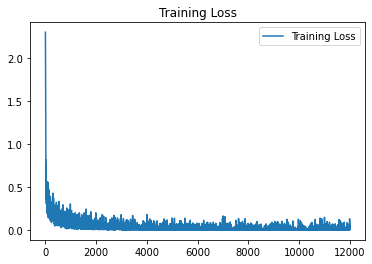

In [34]:
#그래프 확인
plt.plot(loss_value, label='Training Loss')
plt.title('Training Loss')
plt.legend()

Text(0.5, 0, 'Epoch')

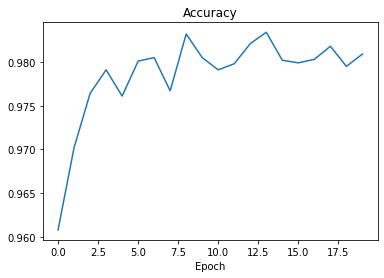

In [35]:
plt.plot(accuracy_value, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')